# PHY1SCA Calorimetry Laboratory

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    from lmfit.models import LinearModel
except ModuleNotFoundError:
    %pip install lmfit --user
    from lmfit.models import LinearModel
from uncertainties import ufloat

Load the data file, which is in plaintext tab-separated variable (TSV) format. The keyword arguments are:
* `index_col=1`: use the first column as an index for the pandas `DataFrame`.

In [19]:
df = pd.read_table("https://gist.githubusercontent.com/rpanderson/362cfcbd8145ea0f8813fb6cbcdf293b/raw/b6f757b6c75571b87a6ad2714bc755b253b1d99d/PHY1SCACalorimetryData.txt", index_col=0)

Inspect the first few rows of the `DataFrame`.

In [20]:
df.head()

,Current (A),Voltage (V),Power (W),Temperature (°C)
Time (s),,,,
0.0,0.96,10.78,10.40,15.6
0.5,0.96,10.78,10.40,15.6
1.0,0.96,10.78,10.40,15.6
1.5,0.96,10.78,10.39,15.6
2.0,0.96,10.78,10.38,15.6


The columns of interest are the final two, which can be accessed easily using `iloc[:, -2:]` (all rows, final two columns). Let's plot these two columns, on different vertical axes.

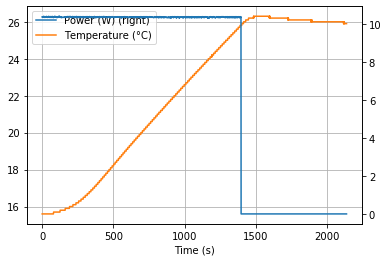

In [21]:
df.iloc[:, -2:].plot(secondary_y='Power (W)', grid=True)

There is some curvature to the data at the start of the heating phase, due to the resistor becoming uniformly heated and not stirring the water adequately. Therefore, we need to limit the linear regression to an interval between 400s and 1380s. We consider the cooling rate over a 10 minute interval after turning the heater off.

In [22]:
# Define time intervals over which to extract a heating/cooling rate
t_heating = (400, 1380)
t_cooling = (1500, 2200)

# Extract sub-frames corresponding to these intervals
df_heating = df.loc[t_heating[0] : t_heating[1]]
df_cooling = df.loc[t_cooling[0] : t_cooling[1]]

# Ensure that the heater was/wasn't on during each phase
assert df_heating["Power (W)"].min() > 10.0
assert df_cooling["Power (W)"].max() < 1e-3

In [23]:
# Perform the linear regression on each interval
model = LinearModel()
heating_fit = model.fit(df_heating["Temperature (°C)"], x=df_heating.index)
cooling_fit = model.fit(df_cooling["Temperature (°C)"], x=df_cooling.index)

Now display each of these fits: 

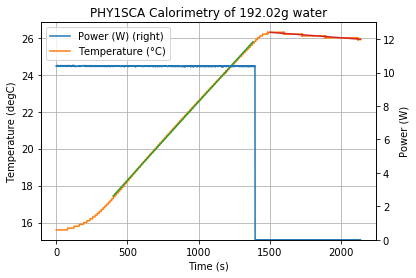

In [31]:
fig, ax = plt.subplots()
df.iloc[:, -2:].plot(secondary_y="Power (W)", grid=True, ax=ax)
ax.plot(df_heating.index, heating_fit.eval(x=df_heating.index), label="heating")
ax.plot(df_cooling.index, cooling_fit.eval(x=df_cooling.index), label="cooling")
ax.set_ylabel('Temperature (degC)')
plt.ylabel('Power (W)')
plt.title('PHY1SCA Calorimetry of 192.02g water')
plt.axis(ymin=0, ymax=13)
plt.savefig('PHY1SCACalorimetryPlot.png')
plt.show()

Let's analyse the gradients and power data to determine the heating rate.

The parameter tables for the linear regression can be printed quite simply using: 

In [45]:
heating_fit.params

name,value,standard error,relative error,initial value,min,max,vary
slope,0.00851390,4.2320e-06,(0.05%),1.0,-inf,inf,True
intercept,14.0324709,0.00395237,(0.03%),0.0,-inf,inf,True


In [46]:
cooling_fit.params

name,value,standard error,relative error,initial value,min,max,vary
slope,-5.8765e-04,5.1564e-06,(0.88%),1.0,-inf,inf,True
intercept,27.1762311,0.00941937,(0.03%),0.0,-inf,inf,True


Now get the heating and cooling rates and convert these to `ufloat` (floating point numbers with uncertainties, from the excellent `uncertainties` package).

In [47]:
dTdt_heating = heating_fit.params["slope"]
dTdt_heating = ufloat(dTdt_heating.value, dTdt_heating.stderr)

dTdt_cooling = cooling_fit.params["slope"]
dTdt_cooling = ufloat(dTdt_cooling.value, dTdt_cooling.stderr)

print(
    "Heating rate = {:.1uS} K/s; Cooling rate = {:.1uS} K/s; ratio = {:.1uS}".format(
        dTdt_heating, -dTdt_cooling, -dTdt_cooling / dTdt_heating
    )
)

Heating rate = 0.008514(4) K/s; Cooling rate = 0.000588(5) K/s; ratio = 0.0690(6)


The heating power, corrected for heat loss, is given by:

$$\frac{dQ}{dt} = \frac{VI}{1 - (dT/dt)_{\text{cooling}}/(dT/dt)_{\text{heating}}} \approx VI \left( 1 + \frac{(dT/dt)_{\text{cooling}}}{(dT/dt)_{\text{heating}}} \right)\,.$$

In [49]:
VI = ufloat(df_heating['Power (W)'].mean(), df_heating['Power (W)'].std())
f"VI = {VI:.1uS} W"

'VI = 10.38(2) W'

We posit that actual electrical power was 30% lower than this, owing to power losses in other parts of the heating circuit. This is consistent with (but not necessarily definitively so) the systematic error one obtains when not correcting the applied power (40% inaccuracy, cf. 0.1% precision).

In [50]:
VI *= 0.7

In [51]:
dQdt = VI / (1 - dTdt_cooling / dTdt_heating)
print('Heating power = {:.1uS} W'.format(dQdt))

Heating power = 6.80(1) W


We can use this to compute

$$\frac{dQ}{dT} = \frac{dQ/dT}{(dT/dt)_{\text{heating}}} \, ,$$

and the specific heat capacity via the known mass $m$:

$$c = \frac{1}{m}\frac{dQ}{dT} \, .$$

The cool thing about doing these calculations with the `ufloat` type is that it handles the uncertainty propagation inherently! 

In [52]:
dQdT = dQdt / dTdt_heating
mass = ufloat(193.84e-3, 0.1e-3)
c_measured = dQdT / mass
print('specific heat capacity = {:.1uS} J/(kg-K)'.format(c_measured))

specific heat capacity = 4119(7) J/(kg-K)


Let's now quantify the precision and accuracy via:

* precision = $\text{u}(c_{\text{measured}}) / c_{\text{measured}}$, and
* accuracy = $(c_{\text{measured}} - c_{\text{accepted}}) / c_{\text{accepted}}$,

where $c_{\text{accepted}} = 4186\,\text{J/(kg-K)}$.

In [53]:
precision = c_measured.s/c_measured.n

c_accepted = 4186
accuracy = (c_measured.n - c_accepted) / c_accepted

print(f'precision = {100*precision:.1f} % ; accuracy = {100*accuracy:.1f} %')

precision = 0.2 % ; accuracy = -1.6 %


Check the alternative approach of computing $dQ/dT$ directly from $VI$ and the heating/cooling rates, viz:

$$\frac{dQ}{dT} = \frac{VI}{(dT/dt)_{\text{heating}} - (dT/dt)_{\text{cooling}}} = \frac{VI}{(dT/dt)_{\text{heating}} + |(dT/dt)_{\text{cooling}}|} \, .$$

In [54]:
dQdT_alt = VI / (dTdt_heating - dTdt_cooling)

The two methods are in complete agreement!

In [55]:
dQdT_alt / dQdT

1.0000000000000002+/-2.2439692680203476e-19

Had we not made the correction, the inferred specific heat capacity would have been three times worse:

In [57]:
dQdT_no_loss = VI / dTdt_heating
c_no_loss = dQdT_no_loss / mass
accuracy_no_loss = (c_no_loss.n - c_accepted) / c_accepted

print('specific heat capacity (no loss) = {:.1uS} J/(kg-K)'.format(c_no_loss))
print(f'accuracy (no loss) = {100 * accuracy_no_loss:.1f} %')
print(f'accurcy improvement = {abs(accuracy_no_loss / accuracy) :.1f}x')

specific heat capacity (no loss) = 4403(7) J/(kg-K)
accuracy (no loss) = 5.2 %
accurcy improvement = 3.2x
